In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import math
import copy
import pdb
import os
import time
from datetime import datetime
from datetime import date
import shelve
# print( math.exp(3) )
import matplotlib.pyplot as plt
plt.style.use('classic')

%matplotlib inline

import seaborn as sns

In [2]:
# Get Earthquake data
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in dates]

df_raw = pd.read_csv('./USGS_Earthquake_US/crime_processed_region.csv', parse_dates=['datetime_occur']);

print("Keys")
print(df_raw.keys())
display(df_raw)
# Change the date time
#df_raw['date'] = df.apply(lambda x: pd.to_datetime(x['datetime_occur'][0:10]),axis=1)

Keys
Index(['datetime_occur', 'latitude', 'longitude', 'depth', 'mag', 'magType',
       'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'crime_region'],
      dtype='object')


,datetime_occur,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,crime_region
0,1986-07-31 23:56:36.830000+00:00,37.488500,-118.370667,5.474,1.66,md,18.0,71.00,0.05135,0.0700,...,"12 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.23,0.69,0.240,11.0,reviewed,nc,nc,CA
1,1986-07-31 23:55:20.800000+00:00,40.769167,-111.897167,-3.070,1.29,md,6.0,181.00,0.06847,0.1300,...,"1 km NNW of Salt Lake City, Utah",earthquake,0.65,0.66,NaN,2.0,reviewed,uu,uu,UT
2,1986-07-31 23:53:56.790000+00:00,37.484167,-118.388833,5.914,1.67,md,13.0,131.00,0.06306,0.0600,...,"11 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.58,0.95,0.100,8.0,reviewed,nc,nc,CA
3,1986-07-31 23:50:03.600000+00:00,37.441833,-118.351167,5.424,1.58,md,16.0,221.00,0.06306,0.0300,...,"8 km NE of Dixon Lane-Meadow Creek, California",earthquake,1.08,1.15,0.170,8.0,reviewed,nc,nc,CA
4,1986-07-31 23:48:11.090000+00:00,41.777000,-112.179667,-2.560,1.55,md,12.0,66.00,0.18680,0.2600,...,"2 km WSW of Riverside, Utah",earthquake,0.66,3.21,NaN,4.0,reviewed,uu,uu,UT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298499,2022-01-01 00:08:58.970000+00:00,38.788833,-122.762833,1.710,1.09,md,41.0,66.00,0.01202,0.0600,...,"1km NNW of The Geysers, CA",earthquake,0.15,0.24,0.176,7.0,reviewed,nc,nc,CA
1298500,2022-01-01 00:08:48.730000+00:00,34.051167,-117.213833,14.000,1.61,ml,55.0,50.00,0.07007,0.1300,...,"3km W of Redlands, CA",earthquake,0.13,0.36,0.174,23.0,reviewed,ci,ci,CA
1298501,2022-01-01 00:05:51.536000+00:00,40.148400,-119.636000,5.200,1.40,ml,9.0,179.27,0.07700,0.1461,...,"22 km N of Sutcliffe, Nevada",earthquake,NaN,1.50,0.350,8.0,reviewed,nn,nn,NV
1298502,2022-01-01 00:04:07.650000+00:00,33.319000,-116.849833,10.580,1.00,ml,30.0,41.00,0.03615,0.1400,...,"4km SSE of Palomar Observatory, CA",earthquake,0.18,0.37,0.156,17.0,reviewed,ci,ci,CA


In [3]:
# Keep mag 0
df = df_raw[df_raw['mag'] > 0].reset_index(drop=True)

# Keep after 2014-01-01
df = df[df['datetime_occur']> pd.to_datetime('2014-01-01', utc=True)]
display(df.groupby('crime_region').size().sort_values(ascending=False).iloc[0:8])

crime_region
CA    370188
AK    327408
HI     80746
NV     78107
PR     35280
OK     19623
PW     19013
WA     16560
dtype: int64

In [4]:
# Add Date 
df['date'] = df.apply(lambda x: x['datetime_occur'].strftime('%Y-%m-%d'), axis=1)

In [5]:
# Keep AK, PW, CA, PR, HI
#df_states = df[df['crime_region'].isin(['AK', 'PW', 'CA', 'PR', 'HI'])].reset_index(drop=True)
df_states = df[df['crime_region'].isin(['AK'])].reset_index(drop=True)


,crime_region,date,0
0,AK,2014-01-01 00:00:00+00:00,352
1,AK,2014-01-06 00:00:00+00:00,520
2,AK,2014-01-11 00:00:00+00:00,417
3,AK,2014-01-16 00:00:00+00:00,463
4,AK,2014-01-21 00:00:00+00:00,401
...,...,...,...
508,AK,2022-01-09 00:00:00+00:00,823
509,AK,2022-01-14 00:00:00+00:00,663
510,AK,2022-01-19 00:00:00+00:00,550
511,AK,2022-01-24 00:00:00+00:00,669


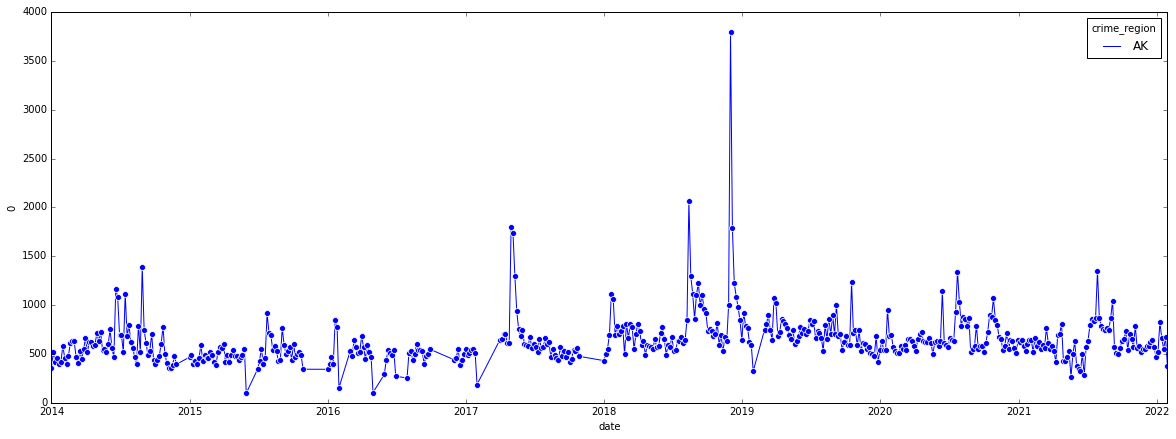

In [7]:

df_states_year = (df_states.assign(date=df_states['datetime_occur'])
        .groupby(['crime_region', pd.Grouper(key='date', freq='5D')])
        .size()
        .reset_index())

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(data=df_states_year, x="date", y=0, hue="crime_region", marker = 'o')

display(df_states_year)


In [ ]:
USGS_Earthquake_CA

In [3]:
# Get Earthquake data
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in dates]

df_raw = pd.read_csv('./USGS_Earthquake_CA/crime_processed_region.csv', parse_dates=['datetime_occur']);

print("Keys")
print(df_raw.keys())
display(df_raw)

Keys
Index(['datetime_occur', 'latitude', 'longitude', 'depth', 'mag', 'magType',
       'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'crime_region'],
      dtype='object')


,datetime_occur,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,crime_region
0,1986-07-31 23:56:36.830000+00:00,37.488500,-118.370667,5.474,1.66,md,18.0,71.0,0.05135,0.07,...,"12 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.23,0.69,0.240,11.0,reviewed,nc,nc,Mono
1,1986-07-31 23:53:56.790000+00:00,37.484167,-118.388833,5.914,1.67,md,13.0,131.0,0.06306,0.06,...,"11 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.58,0.95,0.100,8.0,reviewed,nc,nc,Mono
2,1986-07-31 23:50:03.600000+00:00,37.441833,-118.351167,5.424,1.58,md,16.0,221.0,0.06306,0.03,...,"8 km NE of Dixon Lane-Meadow Creek, California",earthquake,1.08,1.15,0.170,8.0,reviewed,nc,nc,Inyo
3,1986-07-31 23:36:23.800000+00:00,37.533667,-118.439667,8.518,0.89,md,6.0,123.0,0.06577,0.03,...,"15 km NE of Mesa, California",earthquake,2.03,4.47,0.070,4.0,reviewed,nc,nc,Mono
4,1986-07-31 23:35:24.920000+00:00,37.485167,-118.390500,1.875,1.23,md,7.0,190.0,0.06396,0.04,...,"11 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.64,1.88,0.030,4.0,reviewed,nc,nc,Mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500404,2022-01-01 00:27:51.990000+00:00,40.477167,-124.322333,19.080,2.88,md,27.0,122.0,0.01167,0.10,...,"12km SSW of Ferndale, CA",earthquake,0.34,0.19,0.221,43.0,reviewed,nc,nc,Humboldt
500405,2022-01-01 00:08:58.970000+00:00,38.788833,-122.762833,1.710,1.09,md,41.0,66.0,0.01202,0.06,...,"1km NNW of The Geysers, CA",earthquake,0.15,0.24,0.176,7.0,reviewed,nc,nc,Sonoma
500406,2022-01-01 00:08:48.730000+00:00,34.051167,-117.213833,14.000,1.61,ml,55.0,50.0,0.07007,0.13,...,"3km W of Redlands, CA",earthquake,0.13,0.36,0.174,23.0,reviewed,ci,ci,San Bernardino
500407,2022-01-01 00:04:07.650000+00:00,33.319000,-116.849833,10.580,1.00,ml,30.0,41.0,0.03615,0.14,...,"4km SSE of Palomar Observatory, CA",earthquake,0.18,0.37,0.156,17.0,reviewed,ci,ci,San Diego


In [11]:
# Keep mag 0
df = df_raw[df_raw['mag'] > 0].reset_index(drop=True)

# Keep after 2014-01-01
df = df[df['datetime_occur']> pd.to_datetime('2014-01-01', utc=True)]
#display(df.groupby('crime_region').size().sort_values(ascending=False).iloc[0:8])

ls_retain = df.groupby('crime_region').size().sort_values(ascending=False).iloc[0:8].index.tolist()
print(ls_retain)

['Sonoma', 'Riverside', 'Inyo', 'Mono', 'San Bernardino', 'Lake', 'Imperial', 'San Diego']


In [5]:
# Add Date 
df['date'] = df.apply(lambda x: x['datetime_occur'].strftime('%Y-%m-%d'), axis=1)

In [12]:
df_states = df[df['crime_region'].isin(ls_retain)].reset_index(drop=True)


,crime_region,date,0
0,Imperial,2014-01-01 00:00:00+00:00,39
1,Imperial,2014-01-06 00:00:00+00:00,24
2,Imperial,2014-01-11 00:00:00+00:00,10
3,Imperial,2014-01-16 00:00:00+00:00,14
4,Imperial,2014-01-21 00:00:00+00:00,23
...,...,...,...
4098,Sonoma,2022-01-09 00:00:00+00:00,174
4099,Sonoma,2022-01-14 00:00:00+00:00,207
4100,Sonoma,2022-01-19 00:00:00+00:00,132
4101,Sonoma,2022-01-24 00:00:00+00:00,131


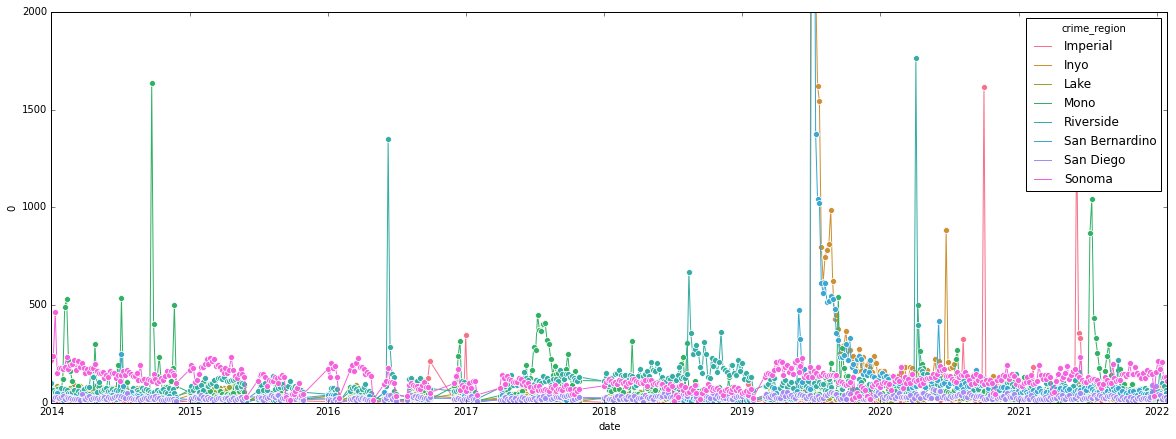

In [14]:

df_states_year = (df_states.assign(date=df_states['datetime_occur'])
        .groupby(['crime_region', pd.Grouper(key='date', freq='5D')])
        .size()
        .reset_index())

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(data=df_states_year, x="date", y=0, hue="crime_region", marker = 'o')

axes.set_ylim([0, 2000])
display(df_states_year)


In [15]:
# Get Earthquake data
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in dates]

df_raw = pd.concat( [pd.read_csv('./USGS_Earthquake_CA/crime_processed_region.csv', parse_dates=['datetime_occur'])\
 ,pd.read_csv('./USGS_Earthquake_AK/crime_processed_region.csv', parse_dates=['datetime_occur'])], axis=0 ).reset_index(drop=True);

print("Keys")
print(df_raw.keys())
display(df_raw)

Keys
Index(['datetime_occur', 'latitude', 'longitude', 'depth', 'mag', 'magType',
       'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'crime_region'],
      dtype='object')


,datetime_occur,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,crime_region
0,1986-07-31 23:56:36.830000+00:00,37.488500,-118.370667,5.474,1.66,md,18.0,71.0,0.05135,0.07,...,"12 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.23,0.69,0.240,11.0,reviewed,nc,nc,Mono
1,1986-07-31 23:53:56.790000+00:00,37.484167,-118.388833,5.914,1.67,md,13.0,131.0,0.06306,0.06,...,"11 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.58,0.95,0.100,8.0,reviewed,nc,nc,Mono
2,1986-07-31 23:50:03.600000+00:00,37.441833,-118.351167,5.424,1.58,md,16.0,221.0,0.06306,0.03,...,"8 km NE of Dixon Lane-Meadow Creek, California",earthquake,1.08,1.15,0.170,8.0,reviewed,nc,nc,Inyo
3,1986-07-31 23:36:23.800000+00:00,37.533667,-118.439667,8.518,0.89,md,6.0,123.0,0.06577,0.03,...,"15 km NE of Mesa, California",earthquake,2.03,4.47,0.070,4.0,reviewed,nc,nc,Mono
4,1986-07-31 23:35:24.920000+00:00,37.485167,-118.390500,1.875,1.23,md,7.0,190.0,0.06396,0.04,...,"11 km NNE of Dixon Lane-Meadow Creek, California",earthquake,0.64,1.88,0.030,4.0,reviewed,nc,nc,Mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885500,2022-01-01 01:38:57.636000+00:00,52.922000,-163.660500,10.000,3.10,ml,NaN,257.0,1.69500,0.47,...,"194 km SE of Akutan, Alaska",earthquake,3.60,1.90,0.105,12.0,reviewed,us,us,Aleutians East
885501,2022-01-01 01:31:04.472000+00:00,63.264700,-150.722700,8.100,1.70,ml,NaN,NaN,NaN,0.83,...,Central Alaska,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak,Denali
885502,2022-01-01 01:09:29.360000+00:00,56.998900,-155.254700,12.600,1.60,ml,NaN,NaN,NaN,0.80,...,"66 km W of Akhiok, Alaska",earthquake,NaN,0.90,NaN,NaN,reviewed,ak,ak,Kodiak Island
885503,2022-01-01 00:21:53.149000+00:00,59.429000,-152.964800,94.600,1.70,ml,NaN,NaN,NaN,0.28,...,"59 km W of Nanwalek, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak,Kenai-Cook Inlet


In [30]:
# Keep mag 0
df = df_raw[df_raw['mag'] > 0].reset_index(drop=True)

# Keep after 2014-01-01
df = df[df['datetime_occur']> pd.to_datetime('2014-01-01', utc=True)]
#display(df.groupby('crime_region').size().sort_values(ascending=False).iloc[0:8])

ls_retain = df.groupby('crime_region').size().sort_values(ascending=False)
ls_retain = ls_retain[ls_retain>10000]
print(ls_retain)
ls_retain = ls_retain.index.tolist()

print(ls_retain)

crime_region
Sonoma                  62160
Matanuska-Susitna       59945
Riverside               53853
Inyo                    50827
Aleutians West          45947
Mono                    43907
San Bernardino          43286
Kenai-Cook Inlet        43121
Denali                  28464
Koyukuk-Middle Yukon    25311
Lake                    18640
Aleutians East          17579
Yakutat                 15675
Imperial                14702
San Diego               14632
Kodiak Island           14049
North Slope             13187
Chugach                 10105
dtype: int64
['Sonoma', 'Matanuska-Susitna', 'Riverside', 'Inyo', 'Aleutians West', 'Mono', 'San Bernardino', 'Kenai-Cook Inlet', 'Denali', 'Koyukuk-Middle Yukon', 'Lake', 'Aleutians East', 'Yakutat', 'Imperial', 'San Diego', 'Kodiak Island', 'North Slope', 'Chugach']


In [27]:
# Add Date 
df['date'] = df.apply(lambda x: x['datetime_occur'].strftime('%Y-%m-%d'), axis=1)

In [28]:
df_states = df[df['crime_region'].isin(ls_retain)].reset_index(drop=True)


,crime_region,date,0
0,Aleutians East,2014-01-01 00:00:00+00:00,11
1,Aleutians East,2014-01-05 00:00:00+00:00,11
2,Aleutians East,2014-01-09 00:00:00+00:00,10
3,Aleutians East,2014-01-13 00:00:00+00:00,2
4,Aleutians East,2014-01-17 00:00:00+00:00,9
...,...,...,...
11404,Yakutat,2022-01-15 00:00:00+00:00,18
11405,Yakutat,2022-01-19 00:00:00+00:00,10
11406,Yakutat,2022-01-23 00:00:00+00:00,12
11407,Yakutat,2022-01-27 00:00:00+00:00,7


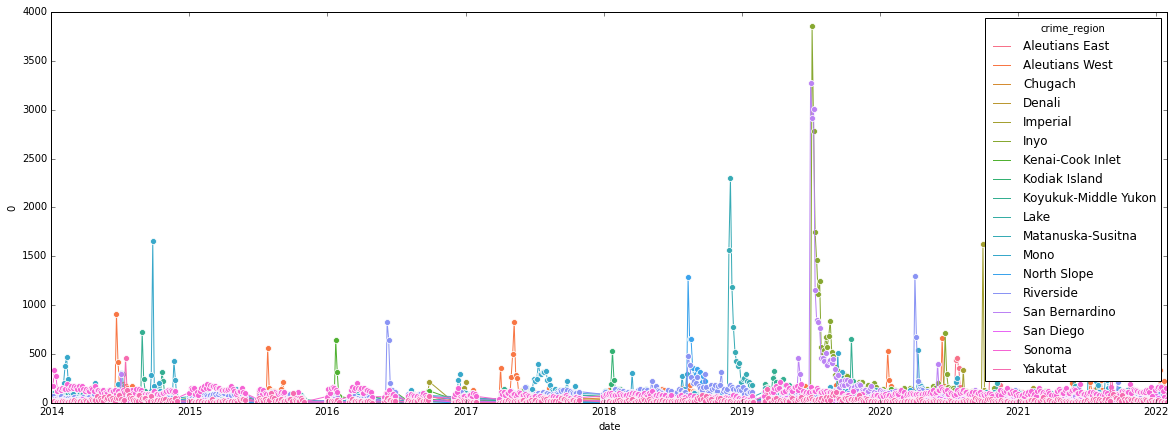

In [32]:

df_states_year = (df_states.assign(date=df_states['datetime_occur'])
        .groupby(['crime_region', pd.Grouper(key='date', freq='4D')])
        .size()
        .reset_index())

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(data=df_states_year, x="date", y=0, hue="crime_region", marker = 'o')

#axes.set_ylim([0, 2000])
display(df_states_year)

In [34]:
df_states.to_csv('./USGS_Earthquake_CAAK/crime_processed_region.csv', index=None)